In [ ]:
import pandas as pd 
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Data Collection 
- **Exports by Value (GASTAT)**  
  Monthly export values, broken down by item nature (Raw, Semi-Finished, Finished).  
  → Used as the dependent variable (trade performance).  

- **Industrial Production Index (IPI)**  
  Monthly production activity by sector (Mining, Manufacturing, Electricity/Gas), base year 2010=100.  
  → Used as the independent variables to capture production-side effects on exports.  

In [183]:
# Reading the Industrial Production Index (IPI) dataset from CSV
ipi_df = pd.read_csv("/Users/farahalhanaya/saudi-trade-ols/Data/index-of-industrial-production-by-section.csv", sep=None, engine="python")

In [184]:
'''
Fetch exports data directly from the API instead of downloading,
as the raw dataset is very large. 

'''
exports_url = "https://database.stats.gov.sa/gastatapi/portal/api/v1/indicators/getData?format=@JSON&api=4111fc52573dfdb7693ec107d8cefe2aee5ff19da62d0ccb82d6c8e626218c19938e942f34ac1f7e2a12176c2ab85f2b8d07752abe70ae7d93510023ce6ac0d1744ddfede8a75743f3362fc678ef0ea472caddadb15fafbf6a57b981e7e1e04c2cb772986fde142c93127cfeca33024d4a1c2a64973596f23ef7b358a134d36e9bb571221e0f65630e21b78a662063b5"
resp = requests.get(exports_url).json()


In [187]:
# Normalize the JSON response to flatten nested records into a tabular format
exports_df = pd.json_normalize(resp['items'])
exports_df.head(5)

,YEAR_TIME,NATURE_CODE,MONTH_TIME,NATURE_ENGL,OBSVALUE_OBSV
0,2021,3,03,Finished Products,14066490955
1,2015,2,02,Semi-Finished Products,10399184772
2,2015,3,11,Finished Products,10528973152
3,2017,1,05,Raw Material,39455503264
4,2024,3,02,Finished Products,23471017998


## Data Preparation  

- Linked the year and month in the exports data into one `Date` column (YYYY-MM) so it matches the format in the IPI data.  

- Filtered the exports data to keep only the years that exist in the IPI dataset, so both are on the same timeline and the analysis is more accurate.  

- Pivoted the exports data so Raw, Semi-Finished, and Finished exports are separate columns. This also made it easy to add a `Total_Exports` column.  

- Merged the exports and IPI data on the `Date` column, so for each month we can compare exports directly with the production indices.  


In [189]:
exports_df['YEAR_TIME'] = exports_df['YEAR_TIME'].astype(str)
exports_df['MONTH_TIME'] = exports_df['MONTH_TIME'].astype(str).str.zfill(2)

# Combine into YYYY-MM format
exports_df['Date'] = exports_df['YEAR_TIME'] + '-' + exports_df['MONTH_TIME']


In [190]:
exports_df.head(5)

,YEAR_TIME,NATURE_CODE,MONTH_TIME,NATURE_ENGL,OBSVALUE_OBSV,Date
0,2021,3,03,Finished Products,14066490955,2021-03
1,2015,2,02,Semi-Finished Products,10399184772,2015-02
2,2015,3,11,Finished Products,10528973152,2015-11
3,2017,1,05,Raw Material,39455503264,2017-05
4,2024,3,02,Finished Products,23471017998,2024-02


In [191]:
ipi_df.rename(columns={"﻿Date": "Date"}, inplace=True)
ipi_df['Date'] = pd.to_datetime(ipi_df['Date'], errors="coerce")

ipi_years = ipi_df['Date'].dt.year.unique()
print("IPI years available in the dataset:", sorted(ipi_years))

ipi_df['Date'] = ipi_df['Date'].dt.strftime("%Y-%m")


IPI years available in the dataset: [np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2023), np.int32(2024), np.int32(2025)]


In [192]:
exports_df['Year'] = exports_df['Date'].str[:4].astype(int)
exports_df = exports_df[exports_df['Year'].isin(ipi_years)]


In [181]:
exports_df.shape

(201, 7)

In [199]:
ipi_df.shape

(201, 3)

In [ ]:
ipi_wide = ipi_df.pivot(
    index="Date",
    columns="Economic Activity",
    values="Industrial Production Index (IPI)"
).reset_index()

ipi_wide.rename(columns={
    "Mining and Quarrying": "Mining_IPI",
    "Manufacturing Industry": "Manufacturing_IPI",
    "Electricity, gas, steam and air conditioning supply": "ElectricityGas_IPI"
}, inplace=True)


In [ ]:
exports_wide = exports_df.pivot(
    index="Date",
    columns="NATURE_ENGL",
    values="OBSVALUE_OBSV"
).reset_index()


exports_wide.rename(columns={
    "Raw Material": "Raw_Exports",
    "Semi-Finished Products": "SemiFinished_Exports",
    "Finished Products": "Finished_Exports"
}, inplace=True)


In [131]:
ipi_wide = ipi_df.pivot_table(
    index="Date",
    columns="Economic Activity",
    values="Industrial Production Index (IPI)",
    aggfunc="mean"
).reset_index()

ipi_wide.rename(columns={
    "Mining and Quarrying": "Mining_IPI",
    "Manufacturing Industry": "Manufacturing_IPI",
    "Electricity, gas, steam and air conditioning supply": "ElectricityGas_IPI"
}, inplace=True)


In [193]:
merged_df = pd.merge(exports_wide, ipi_wide, on="Date", how="inner")
merged_df.head(5)



,Date,Finished_Exports,Raw_Exports,SemiFinished_Exports,Total_Exports,ElectricityGas_IPI,Manufacturing_IPI,Mining_IPI
0,2018-01,14227801490,55980122099,14030593378,559801220991403059337814227801490,60.55,171.27,122.27
1,2018-02,13539114605,49383815988,14626766097,493838159881462676609713539114605,71.77,173.65,121.68
2,2018-03,15606879473,51472061479,15367837341,514720614791536783734115606879473,91.95,179.10,121.34
3,2018-04,16140452208,58268609633,15241250532,582686096331524125053216140452208,115.21,183.92,120.86
4,2018-05,17362020883,62162495003,16874953260,621624950031687495326017362020883,139.90,185.71,122.84


## OLS Regression  

- Started with a correlation heatmap to see how the variables are linked together.  

- Built the OLS regression model with Total Exports as the dependent variable and the three IPI sectors (Mining, Manufacturing, Electricity/Gas) as the independent variables.  

- The model helps us check how changes in industrial production are affecting Saudi Arabia’s trade performance, and also gives us predicted exports based on the IPIs.  


In [ ]:
# Getting the total exports by summing all the sub exports
merged_df['Total_Exports'] = (
    pd.to_numeric(merged_df['Raw_Exports'], errors='coerce') +
    pd.to_numeric(merged_df['SemiFinished_Exports'], errors='coerce') +
    pd.to_numeric(merged_df['Finished_Exports'], errors='coerce')
)

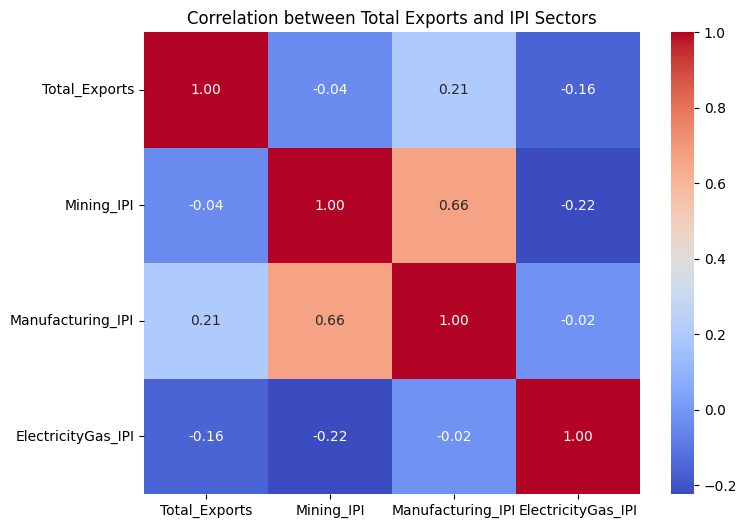

In [195]:
'''
In this heatmap, we check how each independent variable (IPI sector) is correlated with Total Exports. 
This helps us see which sector moves more closely with exports before running the regression.

'''
corr = merged_df[['Total_Exports',
                  'Mining_IPI','Manufacturing_IPI','ElectricityGas_IPI']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Total Exports and IPI Sectors")
plt.show()


In [ ]:
# Independent variables (X) which is the IPI sectors we’re testing as predictors
X = merged_df[['Mining_IPI','Manufacturing_IPI','ElectricityGas_IPI']]
X = sm.add_constant(X) 

# Dependent variable (y) which is the total exports that we want to predict
y = merged_df['Total_Exports']

ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:          Total_Exports   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     3.757
Date:                Sat, 20 Sep 2025   Prob (F-statistic):             0.0151
Time:                        22:25:24   Log-Likelihood:                -1668.9
No. Observations:                  67   AIC:                             3346.
Df Residuals:                      63   BIC:                             3355.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.432e+11   2.22

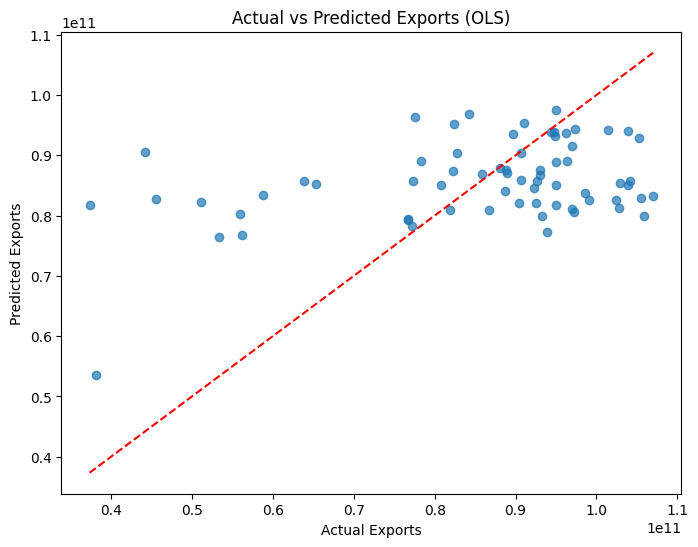

In [173]:
y_pred = ols_model.predict(X)

plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--') 
plt.xlabel("Actual Exports")
plt.ylabel("Predicted Exports")
plt.title("Actual vs Predicted Exports (OLS)")
plt.show()


## Model Interpretation

From the regression results, the IPIs we used (Mining, Manufacturing, Electricity/Gas) explain about **15% of the changes in total exports**.  

- **Mining_IPI** → negative and significant.  
  If mining activity goes up, exports actually go down.  

- **Manufacturing_IPI** → positive and significant.  
  When manufacturing increases, exports increase too.  

- **ElectricityGas_IPI** → weak negative effect, almost significant.  
  Higher electricity/gas activity might slightly lower exports, but it’s not very strong.  

The scatter plot (actual vs predicted) shows that the model is following the general export trend, but it still underestimates the higher values and overestimates the lower ones.  

The R² is not high, so clearly exports are also affected by other factors (like oil prices, global demand, policies, etc.), not just the IPIs.  

### Concerns
There are a few things to keep in mind:  
- The residuals show autocorrelation (Durbin-Watson = 0.37), which is common with time-series data.  
- The IPIs are correlated with each other, so there’s some multicollinearity.  
- The spread of errors isn’t even, meaning heteroscedasticity might be present.  
- Residuals are also not perfectly normal, which affects how reliable the predictions are.  

### Recommendations
- What stands out is that manufacturing is the strongest positive link with exports. Mining, on the other hand, pulls exports down, while electricity/gas has a small negative role. Based on this, strengthening manufacturing capacity and making energy use more efficient could support trade. At the same time, relying too heavily on mining exports doesn’t seem to boost performance, so diversifying into other areas and connecting exports more with global demand and trade agreements might be more effective.  

Overall, the model gives a good starting point, but it also makes it clear that exports are shaped by bigger global and policy factors beyond local production activity.  
